<a href="https://colab.research.google.com/github/ameyakarnad/BeerPersonalization/blob/master/Personalisation_Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beer Recommendation
Fall 2018, 4571 Recommendation System Final Project


##### Background
For this project, we pretend to be an online craft beer retailer. We want to develop an algorithm to make purchase recommendations to our customers when they visit our website. The recommendations should be personalized based on the customer’s taste and preferences while helping customers discover new beers they have not tried before. We would be recommending each user up to **10 Unranked** recommended items each time they visit our website.


##### Challenges
Our project will focus on tackling the following challenges
- How can we build recommendations that take into account user preferences and taste?
- How do we ensure that there is enough variety among the set of beers that are recommended during each user session?
- How do we encourage users to explore beers/styles that they have not tried before - either because they are newly released items (not many reviews) or because they are a different type than the one usually consumed by the user? (serendipitous recommendations/novelty items)
- How do we provide recommendations for users that just joined the service? (cold start problem)



##### Project in Abstract
- Exploratory Data Analysis of the beer data
- Implementation and Comparision of  the performance of different algorithms among users/items with different number of reviews  (SVD , NMF, KNN and NLP Content based model(CBM))
- Model Evaluation based on accuracy
- Variety and Serendipity metrics and evaluation
- Tackling the Cold Start Problem



##### Approach


Our recommendations will be based on a number of different approaches, each of them targeting to one of more business challenges
- Collaborative filtering/model based methods (targeting challenge #1)
- Popular items (#3, #4)
- Item based features (#2, #3)
- User Preferences (#4)

.


##### Data Source
- Data source: the BeerAdvocate dataset of beer reviews 
- We pretend that the data represents reviews given by our user base after trying different beers. Each entry in the dataset includes information such as userID, beerID, ratings (aroma, appearance, overall, etc) from 1 to 5, and review text.


## Part 1: Data Preprocessing

In [1]:
# based on Google Colab 
# python 3
!pip install scikit-surprise

In [0]:
import pandas as pd
import numpy as np
import os
import itertools as it
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import gzip

from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
from surprise.model_selection import train_test_split
from surprise import NMF, Reader, Dataset, SVD, NMF, accuracy, KNNWithMeans

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 1.1 Load Data

In [0]:
# load metadata from Google Drive 
# save as a list
with gzip.open('/content/gdrive/My Drive/Final Project/Beeradvocate.txt.gz', 'r') as f:
  rb_file = f.readlines()
data = []
row_out = []

for i in rb_file:
    row = i.decode('utf-8', errors = 'replace')
    #print(row)
    if row == '\n':
      data.append(row_out)
      row_out = []
      continue
    cat, field = row.split(":", 1)
    #remove leading white spaces
    field = field.rstrip()
    row_out.append(field)

In [0]:
# convert list to dataframe
column_names = ['beer_name', 'beer_beerId', 'beer_brewer', 'beer_ABV', 'beer_style', 
                'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 
                'review_overall', 'review_time', 'review_profileName', 'review_text']

df = pd.DataFrame.from_records(data, columns=column_names)

In [6]:
# descriptive 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
beer_name             1586614 non-null object
beer_beerId           1586614 non-null object
beer_brewer           1586614 non-null object
beer_ABV              1586614 non-null object
beer_style            1586614 non-null object
review_appearance     1586614 non-null object
review_aroma          1586614 non-null object
review_palate         1586614 non-null object
review_taste          1586614 non-null object
review_overall        1586614 non-null object
review_time           1586614 non-null object
review_profileName    1586614 non-null object
review_text           1586614 non-null object
dtypes: object(13)
memory usage: 157.4+ MB


In [7]:
df.head(3)

,beer_name,beer_beerId,beer_brewer,beer_ABV,beer_style,review_appearance,review_aroma,review_palate,review_taste,review_overall,review_time,review_profileName,review_text
0,Sausa Weizen,47986,10325,5.00,Hefeweizen,2.5,2,1.5,1.5,1.5,1234817823,stcules,A lot of foam. But a lot.\tIn the smell some ...
1,Red Moon,48213,10325,6.20,English Strong Ale,3,2.5,3,3,3,1235915097,stcules,"Dark red color, light beige foam, average.\tI..."
2,Black Horse Black Beer,48215,10325,6.50,Foreign / Export Stout,3,2.5,3,3,3,1235916604,stcules,"Almost totally black. Beige foam, quite compa..."


In [8]:
print('The full dataset includes:')
print('%d unique beers;' % df.beer_beerId.nunique())
print('%d unique users;' % df.review_profileName.nunique())
print('and %d reviews in total.' % df.shape[0])

The full dataset includes:
66055 unique beers;
33388 unique users;
and 1586614 reviews in total.


### 1.2 Exploratory Data Analysis

#### EDA with respect to users

In [0]:
num_review_byuser = df.review_profileName.value_counts()
freq_list_user = np.array(list(dict(num_review_byuser).values()))

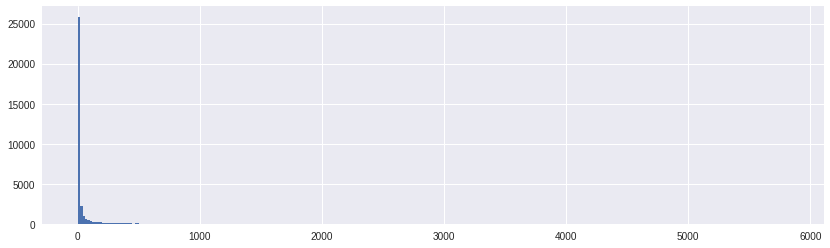

In [10]:
plt.figure(figsize=(14, 4))
plt.hist(freq_list_user, bins=300)
plt.show()

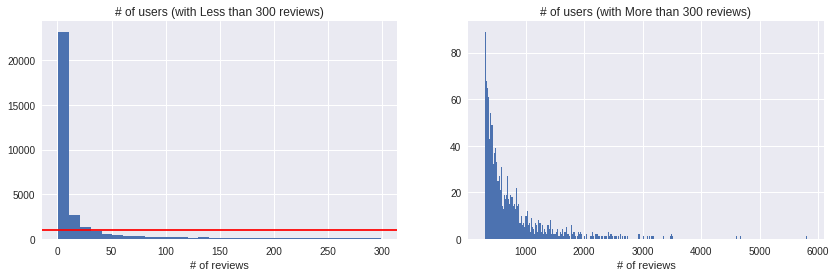

In [11]:
user5more = freq_list_user[np.where(freq_list_user >= 300)]
user5less = freq_list_user[np.where(freq_list_user < 300)]

plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(user5less, bins=30)
plt.title('# of users (with Less than 300 reviews)')
plt.xlabel('# of reviews')
plt.axhline(y=1000, color='r', linestyle='-')

plt.subplot(122)
plt.hist(user5more, bins=300)
plt.title('# of users (with More than 300 reviews)')
plt.xlabel('# of reviews')

plt.show()

We have 33388 unique users, among them ~28000 users have less than 30 reviews.

#### EDA wirth respect to Beers

In [0]:
num_review_bybeer = df.beer_name.value_counts()
freq_list_beer = np.array(list(dict(num_review_bybeer).values()))

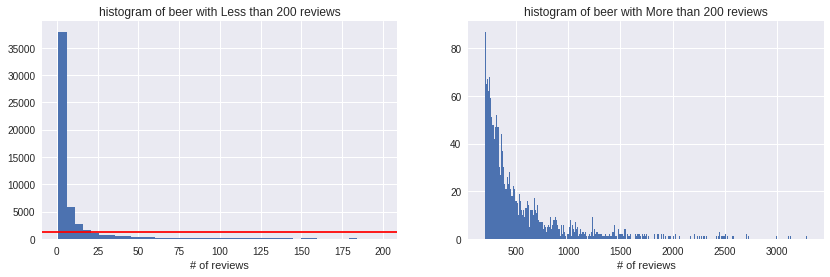

In [13]:
beer5more = freq_list_beer[np.where(freq_list_beer >= 200)]
beer5less = freq_list_beer[np.where(freq_list_beer < 200)]

plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(beer5less, bins=40)
plt.title('histogram of beer with Less than 200 reviews')
plt.xlabel('# of reviews')
plt.axhline(y=1200, color='r', linestyle='-')

plt.subplot(122)
plt.hist(beer5more, bins=300)
plt.title('histogram of beer with More than 200 reviews')
plt.xlabel('# of reviews')

plt.show()

### 1.3 Subset from Metadata

In [14]:
# subset data for collabrotive filtering
df1 = df[['beer_name', 'beer_beerId', 'review_profileName', 'review_overall', 'review_time']]
print('Original data size: %s' % str(df1.shape)) 

# remove NA 
df1 = df1[pd.notnull(df1.beer_name) & pd.notnull(df1.review_profileName) & pd.notnull(df1.review_overall)]
# remove blanks
df1 = df1.loc[df1.review_profileName != '']
df1 = df1.loc[df1.beer_name != '']
df1 = df1.loc[df1.review_overall != '']
print('After removing NAs and blanks: %s' % str(df1.shape)) 

# drop duplicate (beer&user) pairs, keep the latest rating
df1['beer_user_pair'] = df1.beer_name + df1.review_profileName
df1 = df1.sort_values(by=['review_time'], ascending=False).drop_duplicates(subset=['beer_user_pair'])
print('After drop duplicate user-item pairs (only keep the latest rating), data size: %s' % str(df1.shape))

# convert review ratings to numberic
df1.review_overall = pd.to_numeric(df1.review_overall)

Original data size: (1586614, 5)
After removing NAs and blanks: (1586266, 5)
After drop duplicate user-item pairs (only keep the latest rating), data size: (1561405, 6)


In [15]:
df1.head(3)

,beer_name,beer_beerId,review_profileName,review_overall,review_time,beer_user_pair
581215,Pete's Wicked Strawberry Blonde,381,bk3nj,3.0,999999652,Pete's Wicked Strawberry Blonde bk3nj
1023623,Fiji Bitter,1480,Mark,4.0,999980551,Fiji Bitter Mark
1077899,Wolaver's India Pale Ale,399,bcm119,3.5,999903142,Wolaver's India Pale Ale bcm119


#### Subset and remove users with less than 10 reviews and beers with less than 5 reviews

In [16]:
# subset three columns
cf = df1[['review_profileName', 'beer_name', 'review_overall']]

# sort user by # of reviews
cnt_user = dict(num_review_byuser)
cf['user_freq'] = [cnt_user.get(x) for x in cf.review_profileName]

# sort beer by # of reviews
cnt_beer = dict(num_review_bybeer)
cf['beer_freq'] = [cnt_beer.get(x) for x in cf.beer_name]

# drop users with less than 10 reviews
# drop beers with less than 5 reviews
cf = cf.loc[cf.user_freq > 10]
cf = cf.loc[cf.beer_freq > 5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
print('After removing bottom users and beers,')
print('%d unique beers;' % cf.beer_name.nunique())
print('%d unique users;' % cf.review_profileName.nunique())
print('and %d reviews in total.' % cf.shape[0])

After removing bottom users and beers,
18925 unique beers;
10189 unique users;
and 1423856 reviews in total.


In [18]:
cf.head(3)

,review_profileName,beer_name,review_overall,user_freq,beer_freq
581215,bk3nj,Pete's Wicked Strawberry Blonde,3.0,45,298
1023623,Mark,Fiji Bitter,4.0,532,8
1077899,bcm119,Wolaver's India Pale Ale,3.5,175,257


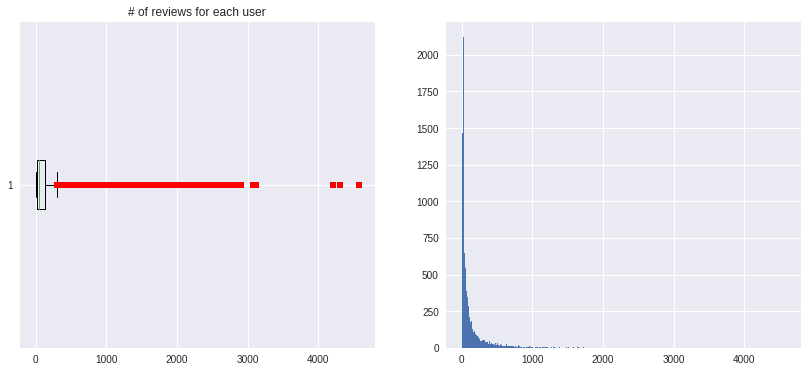

In [19]:
# user 
freq = cf.review_profileName.value_counts()
freq = np.array(list(dict(freq).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freq, 0, 'rs', 0)
plt.title('# of reviews for each user')

plt.subplot(122)
plt.hist(freq, bins=400)

plt.show()

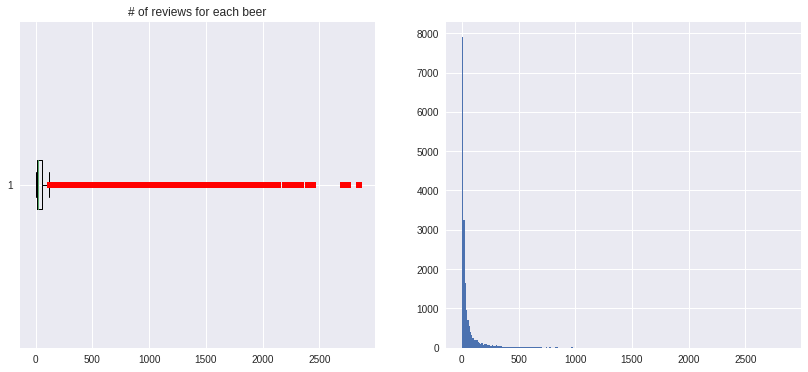

In [20]:
# beer
freqb = cf.beer_name.value_counts()
freqb = np.array(list(dict(freqb).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freqb, 0, 'rs', 0)
plt.title('# of reviews for each beer')

plt.subplot(122)
plt.hist(freqb, bins=250)

plt.show()

#### split into two groups
- users with more than 100 reviews;
- users with less than 100 reviews.

In [21]:
# split into two groups
threshold = 100

more = cf.loc[cf.user_freq > threshold]
less = cf.loc[cf.user_freq <= threshold]

more.head()

,review_profileName,beer_name,review_overall,user_freq,beer_freq
1023623,Mark,Fiji Bitter,4.0,532,8
1077899,bcm119,Wolaver's India Pale Ale,3.5,175,257
797362,Jason,Lindemans Framboise,3.5,2350,903
808675,Jason,Chapeau Framboise Lambic,4.0,2350,44
961766,Jason,Dooryard Ale,3.0,2350,13


group > 100 has the size: (1186781, 5)


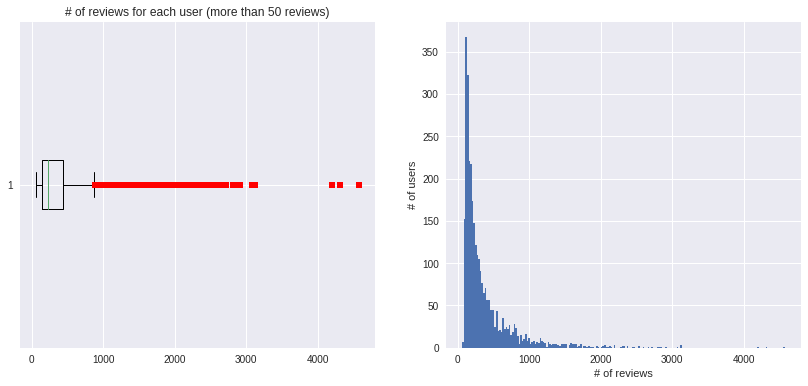

In [22]:
# visualize two groups
print('group > %d has the size: %s' % (threshold, str(more.shape)))

freqm = more.review_profileName.value_counts()
freqm = np.array(list(dict(freqm).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freqm, 0, 'rs', 0)
plt.title('# of reviews for each user (more than 50 reviews)')

plt.subplot(122)
plt.hist(freqm, bins=200)
plt.ylabel('# of users')
plt.xlabel('# of reviews')
plt.show()

group <= 100 has the size: (237075, 5)


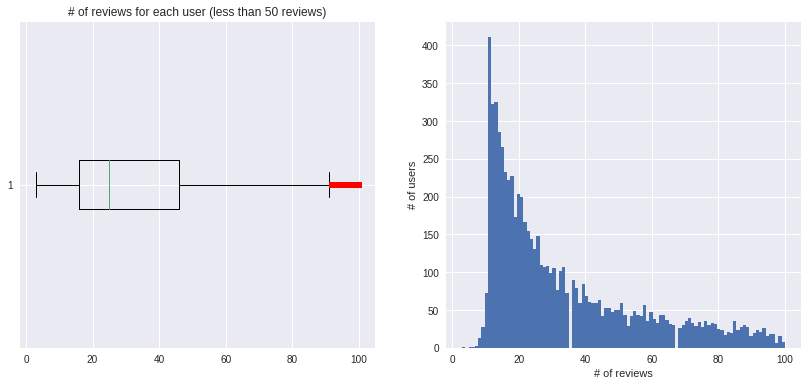

In [23]:
# visualize two groups
print('group <= %d has the size: %s' % (threshold, str(less.shape)))

freql = less.review_profileName.value_counts()
freql = np.array(list(dict(freql).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freql, 0, 'rs', 0)
plt.title('# of reviews for each user (less than 50 reviews)')

plt.subplot(122)
plt.hist(freql, bins=100)
plt.ylabel('# of users')
plt.xlabel('# of reviews')
plt.show()

## Part 2: Prediction Models

We will be comparing the different Prediction models which we tried. The models are 

- SVD 
- NMF
- K nearest neighbours (user based)
- Content based 




We will look at only the overview of the models in this report. The implementations of each of the models will be in seperate files. We will be discussing the results here

Matrix Factorisation (SVD and NMF) https://github.com/ds-personalization/final-project-4571-beer-recommendation/blob/master/Final%20Report/Models/Matrix_Factorisation.ipynb

K nearest neighbours (User based) : https://github.com/ds-personalization/final-project-4571-beer-recommendation/blob/master/Final%20Report/Models/KNN.ipynb

Content based : https://github.com/ds-personalization/final-project-4571-beer-recommendation/blob/master/Final%20Report/Models/Content_based.ipynb 



We also tried to run the KNN item-based 

- Execution failed during runtime twice
- User-based collabrative filtering takes up 12GB+ RAM, reached the limits of Colab and led to kernel crach every time.

## Part 3: Model Comparison

In [0]:
import pickle



svd_pred_df_s = pickle.load(open("/content/gdrive/My Drive/Final Project/svd_rec.sav", 'rb'))
nmf_pred_df_s = pickle.load(open("/content/gdrive/My Drive/Final Project/nmf_rec.sav", 'rb'))
knn_pred_df_s = pickle.load(open("/content/gdrive/My Drive/Final Project/knn_rec.sav", 'rb'))


### 3.1 Summarize model performance
(RMSE for each review_group)

In [0]:
# define function to get group prediction error
def error_bygroup(pred_df, model_name):
  """
  input complete pred_error df
  output pred_error by group
  """
  # cut into groups
  bins = [10, 20, 30, 40, 50, 100, 200, 500, 1000, 2000, 6000]
  labels = ['11-20', '21-30', '31-40', '41-50', '51-100', '101-200', 
            '201-500', '501-1000', '1001-2000', '2001-6000']
  
  # add group label
  pred_df['review_group'] = pd.cut(pred_df['user_freq'], bins = bins, labels = labels)
  
  # calculate group mean
  pred_df = pred_df.groupby('review_group').mean()
  
  # rename the error column
  #pred_df['err'].columns = model_name
  pred_df = pred_df.rename(columns = {'err':model_name})
  return pred_df

In [0]:
# get prediction error
#knn_pred_df = pd.concat([pred_more_df, pred_less_df])
svd_err = error_bygroup(svd_pred_df_s, 'SVD')
nmf_err = error_bygroup(nmf_pred_df_s, 'NMF')

In [0]:
knn_err = error_bygroup(knn_pred_df_s, 'KNN')

In [28]:
svd_err

,rui,est,Iu,Ui,SVD,user_freq
review_group,,,,,,
11-20,3.875504,3.868761,10.068082,485.776423,0.484421,15.274066
21-30,3.867082,3.863895,16.407537,478.374874,0.472094,25.161061
31-40,3.872003,3.870671,22.848575,477.709515,0.451166,35.311755
41-50,3.852469,3.853949,29.627264,470.578429,0.454234,45.462693
51-100,3.861756,3.860684,48.916687,464.865502,0.440030,74.981601
101-200,3.847559,3.844390,96.137930,439.218147,0.428652,148.602393
201-500,3.821546,3.821411,216.369919,385.854022,0.425635,337.693397
501-1000,3.800954,3.801270,455.263834,322.808590,0.415642,723.963372
1001-2000,3.771005,3.769498,856.767886,250.636647,0.430694,1424.637358


In [29]:
# combine three models
final = pd.concat([svd_err['SVD'], nmf_err['NMF'], knn_err['KNN'], 
                   knn_err['KNN']], axis=1)
final

,SVD,NMF,KNN,KNN
review_group,,,,
11-20,0.484421,0.558552,0.563693,0.563693
21-30,0.472094,0.526362,0.520058,0.520058
31-40,0.451166,0.495892,0.461373,0.461373
41-50,0.454234,0.491685,0.448833,0.448833
51-100,0.440030,0.473972,0.421911,0.421911
101-200,0.428652,0.454293,0.406928,0.406928
201-500,0.425635,0.446872,0.406592,0.406592
501-1000,0.415642,0.433712,0.398894,0.398894
1001-2000,0.430694,0.450645,0.421365,0.421365


According to the error matrix above, using two separate groups in KNN will significantly improve model accuracy (column 3 and 4). However, for the purpose of compare model performance over all review groups, we will use the result of 'KNN on whole dataset' for comparison in the following plots.

### 3.2 Visualize

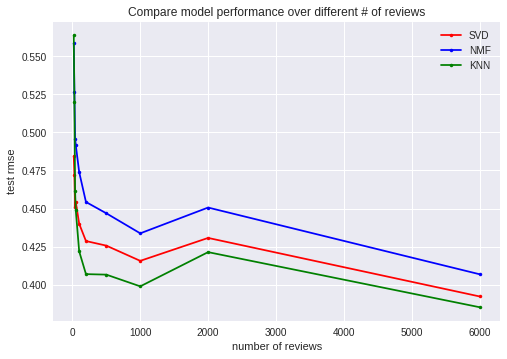

In [30]:
# visualize
x = [20, 30, 40, 50, 100, 200, 500, 1000, 2000, 6000]
y_svd = svd_err['SVD'].values.tolist()
y_nmf = nmf_err['NMF'].values.tolist()
y_knn = knn_err['KNN'].values.tolist()

plt.plot(x, y_svd, '.r-') 
plt.plot(x, y_nmf, '.b-') 
plt.plot(x, y_knn, '.g-') 
plt.legend(('SVD', 'NMF', 'KNN'), loc='upper right')

plt.xlabel('number of reviews')
plt.ylabel('test rmse')
plt.title('Compare model performance over different # of reviews')

plt.show()

According to the plot above, it looks like *KNN* outperforms the other models for reviews greater than 50, we will need to have a closer look

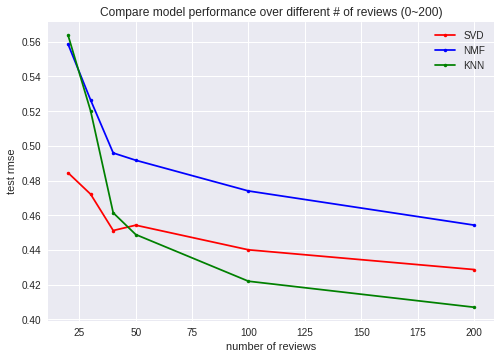

In [31]:
# visualize: reviews 10-200

x = [20, 30, 40, 50, 100, 200]
y_svd = svd_err['SVD'].values.tolist()[:6]
y_nmf = nmf_err['NMF'].values.tolist()[:6]
y_knn = knn_err['KNN'].values.tolist()[:6]

plt.plot(x, y_svd, '.r-') 
plt.plot(x, y_nmf, '.b-') 
plt.plot(x, y_knn, '.g-') 
plt.legend(('SVD', 'NMF', 'KNN'), loc='upper right')

plt.xlabel('number of reviews')
plt.ylabel('test rmse')
plt.title('Compare model performance over different # of reviews (0~200)')

plt.show()

Using a zoom in view, we look at review_group between (10, 200). It becomes clear that *KNN* works the best after ~70 reviews but performs significantly poorly from (10, 70]. According to this plot, we are safe to say that *KNN* is not a good choice for cold start problem, i.e. number of reviews under 30.

None of the models seem to give good accurate results for number of reviews less than 30. So we think that its better to opt for the cold start popularity based recommendations for users with less than **30** reviews


## Part 4: Sample Recommendation
We randomly choose 20 users from the whole dataset (2 from each review_group) to illustrate how our recommendation system works.


#### 4.1 Choose 20 users

In [32]:
user20 = svd_pred_df_s[['uid', 'review_group']].drop_duplicates('uid').sort_values(by='review_group')

# first 10 users
user10 = user20.drop_duplicates('review_group', keep='first')
# 11-20 users
user11 = user20.drop_duplicates('review_group',keep='last')
# combine 
users = pd.concat([user10, user11], axis=0).sort_values(by='review_group')
users

,uid,review_group
299057,bronco94,11-20
1350623,t8s8l8,11-20
471469,kkrez,21-30
227940,SERENGETI,21-30
760795,uabigdaz,31-40
1363754,dmbfrat420beers,31-40
865826,Graham21,41-50
371378,Roderick,41-50
1125490,linnet,51-100
467864,clarkm04,51-100


In [33]:
user20_names = users.uid.tolist()
user20_names

[' bronco94',
 ' t8s8l8',
 ' kkrez',
 ' SERENGETI',
 ' uabigdaz',
 ' dmbfrat420beers',
 ' Graham21',
 ' Roderick',
 ' linnet',
 ' clarkm04',
 ' nickynick',
 ' jdoncbus',
 ' cavedave',
 ' JohnnyDuvel',
 ' craytonic',
 ' Phelps',
 ' rastaman',
 ' twiggamortis420',
 ' mikesgroove',
 ' weeare138']

#### 4.2 Extract their predictions from SVD, NMF KNN and Content based

In [0]:
from collections import defaultdict

## SVD
top_10_svd = defaultdict(list)

for user in user20_names:
    temp = svd_pred_df_s[svd_pred_df_s["uid"] == user]
    for index, row in temp.iterrows():
        if user not in top_10_svd:
            top_10_svd[user] = []
        top_10_svd[user].append((row["iid"], row["est"]))

for uid, user_ratings in top_10_svd.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_10_svd[uid] = user_ratings[:10]

## NMF
top_10_nmf = defaultdict(list)

for user in user20_names:
    temp = nmf_pred_df_s[nmf_pred_df_s["uid"] == user]
    for index, row in temp.iterrows():
        if user not in top_10_nmf:
            top_10_nmf[user] = []
        top_10_nmf[user].append((row["iid"], row["est"]))

for uid, user_ratings in top_10_nmf.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_10_nmf[uid] = user_ratings[:10]
          
          
## knn
top_10_knn = defaultdict(list)

for user in user20_names:
    temp = knn_pred_df_s[knn_pred_df_s["uid"] == user.lstrip()]
    for index, row in temp.iterrows():
        if user not in top_10_knn:
            top_10_knn[user] = []
        top_10_knn[user].append((" " + row["iid"], row["est"]))

for uid, user_ratings in top_10_knn.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_10_knn[uid] = user_ratings[:10]
          
                
top_10_cbm = pickle.load(open("/content/gdrive/My Drive/Final Project/text_recs.sav", 'rb'))

   

The top 10 recomendation were calculate for SVD, NMF and KNN in the previous step while the for content model, it was calculated in the final step of https://github.com/ds-personalization/final-project-4571-beer-recommendation/blob/master/Final%20Report/Models/Content_based.ipynb and stored

## Part 5 : Variety and Serendipity

For the beer recomendation project, we decided to not only focus on the accuracy metric, but also look at other key metrics scuh as variety and serendipity. 

- Variety in recommendation is the variety of different beer that you recommend to the user.
- Serendipity in recommendation are ones that are surprising to the user.

We looked at different papers than tried to solve this problem or even prescribed a metric to evaluate this.  Ziegler, McNee et. al described a metric called as the 'intra-list similarity' in their paper titled "Improving Recommendation Lists Through
Topic Diversification" 
link : http://www2.informatik.uni-freiburg.de/~cziegler/papers/WWW-05-CR.pdf which compares items recommended

For beer recomendation, the similarity between 2 beer is checked by looking at their beer types. If the beer type of both beers being compared are same, then no score is provided. If they are not same, then the score increases

- For Variety, we look at the intralist similarity as suggested by the paper. A total of 45 comparisons are made between all the 10 recomended items. The score lies between 0 and 1 and the higher the score, the more variety in the recomendations.

- The Serendipity is calculated  using a interlist similarity. The 10 recomended items are compared to all the items consumed by the user till date and a metric similar to the intralist similarity is derieved. The score lies between 0 and 1 and the higher the score, the more serendipidy in the recomendations.

As the metrics calculation is time comsuming, we will look at the 20 users that were picked in the previous section

In [0]:
# Variety High score, high variety 

def intra_list_rating(name, recom_list):
    variety = 0 
    for i in range(len(recom_list)):
        for j in range(i+1, len(recom_list)):
            if list(set(df[df['beer_name'] == recom_list[i][0]]['beer_style'])) != list(set(df[df['beer_name'] == recom_list[j][0]]["beer_style"])):
                variety = variety + 1
    count = len(recom_list)
    return variety/(count* (count-1) /2)


#Serendipity, High score, High Serendpity

def inter_list_rating(name, recom_list):
    serendipidy = 0 
    consumed = list(set(df[df['review_profileName'] == name]['beer_style']))
    for beer in consumed:
        for item in recom_list:
            if list(set(df[df['beer_name'] == item[0]]['beer_style']))[0] != beer:
                serendipidy = serendipidy + 1
    
    return serendipidy/(len(recom_list) * len(consumed))
  

def get_average_serendipidy(model_list):
  average = 0
  for user in model_list:
    average = average + inter_list_rating(user,model_list[user])
  average = average/20
  return average



def get_average_variety(model_list):
  average = 0
  for user in model_list:
    average = average + intra_list_rating(user,model_list[user])
  average = average/20
  return average
  
 

### Variety

Let consider the Variety score for all four models.  

In [36]:
print("The Variety score for NMF is ", " %.4f " % get_average_variety(top_10_nmf))
print("The Variety score for SVD is ", " %.4f " % get_average_variety(top_10_svd))
print("The Variety score for KNN is ", " %.4f " % get_average_variety(top_10_knn))
print("The Variety score for CBM is ", " %.4f " % get_average_variety(top_10_cbm))

The Variety score for NMF is   0.9256
The Variety score for SVD is   0.9356
The Variety score for KNN is   0.9511
The Variety Score for CBM is   0.9553


The Variety score for Content based model was slightly better than KNN, which was quite higher than the Matrix factorisation based models 

In [37]:
print("The Serendipidy score for NMF is ", " %.4f " % get_average_serendipidy(top_10_nmf))
print("The Serendipidy score for SVD is ", " %.4f " % get_average_serendipidy(top_10_svd))
print("The Serendipidy score for KNN is ", " %.4f " % get_average_serendipidy(top_10_knn))
print("The Serendipidy score for CBM is ", " %.4f " % get_average_serendipidy(top_10_cbm))


The Serendipidy score for NMF is   0.9603
The Serendipidy score for SVD is   0.9609
The Serendipidy score for KNN is   0.9672
The Serendipidy score for CBM is   0.9664


The Seredipidy score for the KNN was slightly higher that the content based model


By this we can conclude that the KNN mode is better than the other models as its RMSE score is lower than the other models and its variety and serendipidy score are high most of the time compared to other models.

## Part 5 : Cold Start Problem

One of the Engineering concers that we faced during the project, was the Cold Start problem. The cold start problem is faced while trying to recommend beer to users about whom we do not have sufficient information to make an accurate predection. This problem is also faced when the recommendation have to be made for a new user who is using the application for the first time. So, we designed an algorithm which would take over recommending beers to users with no/less reviews, and the switch from cold start algorithm to the main recommendation algorithm would be made once the user has a certain number of reviews

Our Solution to the Cold Start problem :
https://github.com/ds-personalization/final-project-4571-beer-recommendation/blob/master/Final%20Report/Models/Popularity_cold_start.ipynb

## Conclusion and Future Scope. 

In this project, we evaluated 4 different models, that is ,  a NLP Content based model (CBM), a k nearest neighbors based model and a couple of Matrix factorisation based models. Not only we calculated the accuracy metrics for each of the models, we also took aspects like variety and serendipidy into consideration. We also targeted the cold start problem and tried to tackle it effectively

The model that we developed uses a cold start popularity based methodlogy for new users and for users with less than 30 reviews. After we get enough data from the user, we switch to the KNN model which has the highest Accuracy and Serendipidy score and asl has a high variety score.

As future scope of the project , we can build a front end/website with our model giving beer recomendations to users and also taking reviews from them about the beer that they had 
